# NBA Rookie Career Prediction - EDA
by Kevin Götz

## Table of Contents

1. Import Modules & Check Duplicates
2. Data Splitting
3. EDA with Pandas Profiling
4. Deep Dive Missings
5. Deep Dive Correlations
6. Deep Dive Outliers
    - 6.1 Univariate and Contextual Outliers with IQR & Z-Scores
    - 6.2 Global Outliers with Isolation Forest
7. Conclusions & Actions

## 1. Import Modules & Check Duplicates

In [1]:
# check if Kernel runs the correct virtual environment
!where python

C:\Users\Kevin G�tz\venv\nba_rookie\Scripts\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python38\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python39\python.exe
C:\Users\Kevin G�tz\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# Data Munging
import pandas as pd 
import numpy as np 

# Basic EDA
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
pd.set_option('display.max.columns', None)
pd.set_option('display.precision', 2)

# Outlier Detection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Viz
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sns
import plotly.express as px
import missingno

In [3]:
# load the data
veterans = pd.read_csv('../Data/Output/NBA_Player_Stats_Veterans.csv', index_col=0)

In [4]:
# count duplicated rows and drop them if there are any (before train_test_split!) --> there are none

print(f'Number of Duplicate Rows: {veterans.duplicated().sum()}')
print(f'Number of Duplicate Game Statistics: {veterans.duplicated(subset=veterans.columns[4:]).sum()}')

Number of Duplicate Rows: 0
Number of Duplicate Game Statistics: 0


## 2. Data Splitting

For prevention of data leakage we split the data BEFORE EDA and lock away the test set, that we only need to asess the scoring of the final model later on.

In [5]:
# split the data
veterans_train, veterans_test = train_test_split(veterans, test_size=0.20, random_state=8)

In [6]:
# show the data
display(veterans_train)
display(veterans_test)

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
413,Zaza Pachulia,42.0,Ulkerspor,Other Team/Club,19.0,ORL,C,59.0,2.0,11.3,1.2,0.39,0.0,NaN,1.2,0.39,0.39,1.0,0.64,1.2,1.8,0.2,0.4,0.2,0.6,1.5,3.3,10.8,0.3,2.30e-02,14.6
195,Jordan Crawford,27.0,Xavier,College/University,22.0,TOT,SG,42.0,18.0,24.5,4.6,0.38,0.8,0.26,3.8,0.43,0.42,1.7,0.87,0.7,1.8,2.8,0.9,0.1,2.0,1.5,11.7,11.8,-0.6,-2.60e-02,14.1
197,Hassan Whiteside,33.0,Marshall,College/University,21.0,SAC,C,1.0,0.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-17.9,0.0,7.00e-03,24.0
92,Shabazz Muhammad,14.0,California-Los Angeles,College/University,21.0,MIN,SG,37.0,0.0,7.8,1.5,0.46,0.1,0.27,1.5,0.48,0.47,0.7,0.65,0.6,0.8,0.2,0.2,0.0,0.4,0.6,3.9,13.1,0.3,5.30e-02,15.9
146,Brandon Knight,8.0,Kentucky,College/University,20.0,DET,PG,66.0,60.0,32.3,4.8,0.41,1.6,0.38,3.2,0.43,0.48,1.6,0.76,0.5,2.7,3.8,0.7,0.2,2.6,2.3,12.8,11.7,1.3,2.90e-02,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,Draymond Green,35.0,Michigan State,College/University,22.0,GSW,SF,79.0,1.0,13.4,1.1,0.33,0.2,0.21,0.9,0.37,0.35,0.6,0.82,0.7,2.6,0.7,0.5,0.3,0.6,2.0,2.9,7.1,0.6,2.80e-02,14.9
361,Dwight Howard,1.0,Southwest Atlanta Christian Academy,High School,19.0,ORL,PF,82.0,82.0,32.6,4.3,0.52,0.0,0.00,4.3,0.52,0.52,3.4,0.67,3.5,6.5,0.9,0.9,1.7,2.0,2.8,12.0,17.2,7.3,1.31e-01,21.4
497,Mamadou N'diaye,26.0,Auburn,College/University,25.0,TOR,C,3.0,0.0,3.3,0.3,0.25,0.0,NaN,0.3,0.25,0.25,0.7,1.00,0.3,0.3,0.0,0.0,0.0,0.0,1.0,1.3,6.6,0.0,8.30e-02,13.3
340,Jarrett Jack,22.0,Georgia Tech,College/University,22.0,POR,SG,79.0,4.0,20.2,2.4,0.44,0.3,0.26,2.1,0.48,0.47,1.6,0.80,0.2,1.8,2.8,0.5,0.0,1.3,1.7,6.7,12.3,1.2,3.50e-02,14.1


,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
338,Hakim Warrick,19.0,Syracuse,College/University,23.0,MEM,PF,68.0,2.0,10.6,1.5,0.44,0.0,NaN,1.5,0.44,0.44,1.1,0.66,0.6,1.5,0.4,0.2,0.3,0.8,1.7,4.1,11.0,0.8,5.30e-02,15.5
30,Emmanuel Mudiay,7.0,Guangdong Southern Tigers,Other Team/Club,19.0,DEN,PG,68.0,66.0,30.4,4.8,0.36,1.1,0.32,3.8,0.38,0.40,2.1,0.67,0.5,2.9,5.5,1.0,0.5,3.2,2.1,12.8,9.9,-2.1,-4.90e-02,11.8
495,DeShawn Stevenson,23.0,Washington Union,High School,19.0,UTA,SG,40.0,2.0,7.3,0.8,0.34,0.0,0.08,0.8,0.38,0.35,0.7,0.68,0.2,0.5,0.5,0.3,0.1,0.7,0.7,2.2,4.3,-0.4,-7.10e-02,9.9
240,D.J. Augustin,9.0,Texas,College/University,21.0,CHA,PG,72.0,12.0,26.5,3.7,0.43,1.5,0.44,2.2,0.42,0.52,2.9,0.89,0.2,1.6,3.5,0.6,0.0,1.7,1.9,11.8,14.9,5.1,1.28e-01,14.1
162,Cory Joseph,29.0,Texas,College/University,20.0,SAS,PG,29.0,1.0,9.2,0.8,0.31,0.1,0.20,0.7,0.34,0.34,0.4,0.65,0.2,0.7,1.2,0.2,0.1,0.4,0.6,2.0,6.9,0.0,1.00e-03,12.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Shabazz Napier,24.0,Connecticut,College/University,23.0,MIA,PG,51.0,10.0,19.8,1.7,0.38,0.8,0.36,0.9,0.40,0.48,0.9,0.79,0.3,1.9,2.5,0.8,0.1,1.6,1.5,5.1,9.3,0.5,2.40e-02,12.9
312,Sergio Rodriguez,27.0,CB Estudiantes,Other Team/Club,20.0,POR,PG,67.0,1.0,12.9,1.5,0.42,0.4,0.28,1.1,0.50,0.47,0.3,0.81,0.3,1.1,3.3,0.5,0.0,1.1,1.1,3.7,14.1,0.9,5.00e-02,12.4
436,John Salmons,26.0,Miami (FL),College/University,23.0,PHI,PG,64.0,1.0,7.9,0.8,0.41,0.2,0.32,0.6,0.45,0.46,0.4,0.74,0.3,0.7,0.7,0.3,0.1,0.5,0.8,2.1,9.5,0.6,5.80e-02,12.1
420,Mike Dunleavy,3.0,Duke,College/University,22.0,GSW,SF,82.0,3.0,15.9,2.0,0.40,0.6,0.35,1.4,0.43,0.47,1.0,0.78,0.8,1.8,1.3,0.6,0.2,1.0,1.5,5.7,12.5,1.5,5.50e-02,13.9


In [7]:
# lock away the test set
veterans_train.to_csv('../Data/Output/NBA_Player_Stats_Veterans_Train.csv')
veterans_test.to_csv('../Data/Output/NBA_Player_Stats_Veterans_Test.csv')

# delete from RAM so there is no way of mixing up datasets
del veterans_test
del veterans

## 3. EDA with Pandas Profiling

The exploratory data analysis is performed with the pandas_profiling library to gain insights about summary statistics, distributions, correlations and missings quickly. The learnings are then mostly applied in the next notebook after the train-test-split was made to impede data leakage.

In [8]:
# pandas-profiling
report = ProfileReport(veterans_train, title='EDA for NBA Rookie Career Prediction')
report.to_file('..\Data\Output\EDA_Report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


--> The EDA Report as an HTML is too big to display here (Github max = 25MB).

## 4. Deep Dive Missings

Missing values are an important part of the EDA and need special treatment. Missings can be put into three categories: MCAR (Missing Completely at Random), MAR (Missing at Random) and MNAR (Missing Not at Random). Only if the data is MCAR (which needs stong assumptions) we can drop the rows, otherwise there is some valuable information in the missings. 

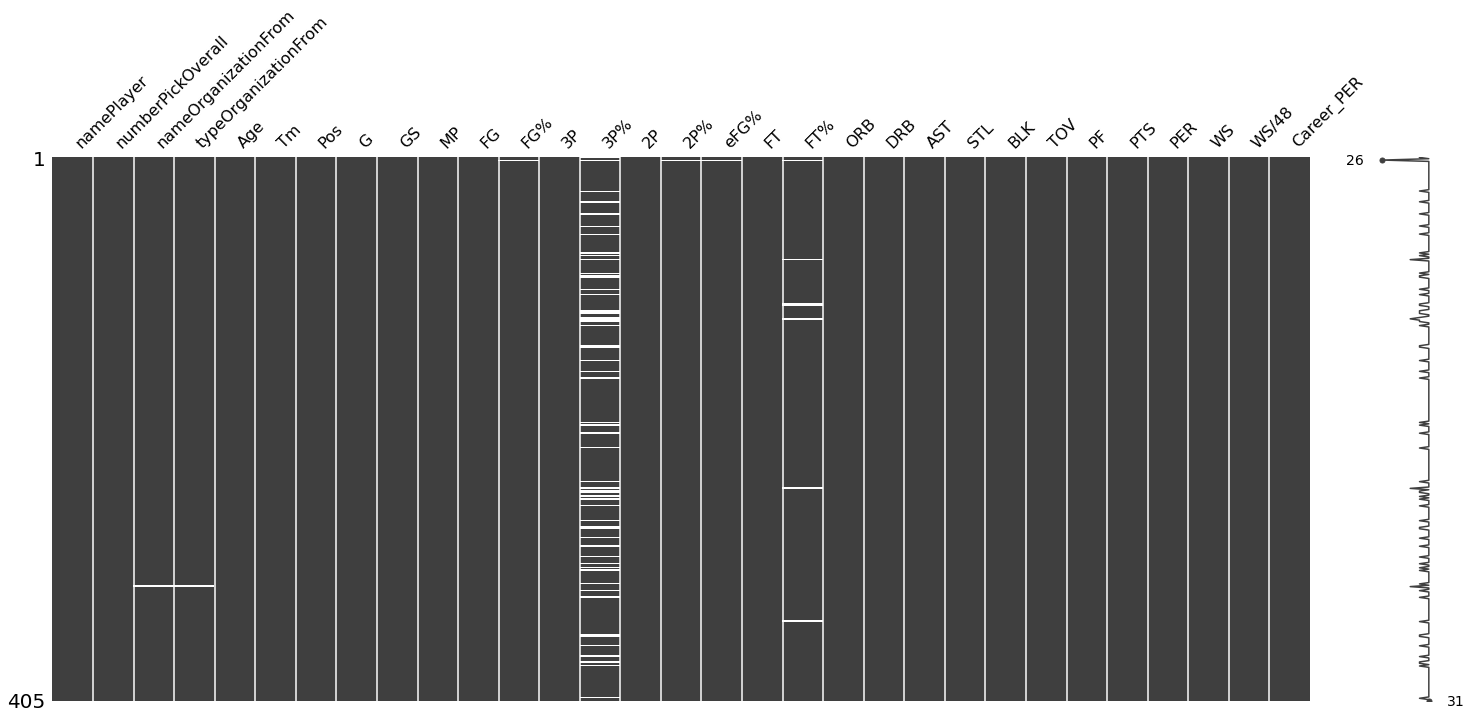

In [9]:
# inspect the missing values  --> it is mostly the 3 pointers efficiency (3P%)
missingno.matrix(veterans_train)
plt.show()

In [10]:
# inspecting all rows with any missing value
veterans_train[veterans_train.isnull().any(axis=1)].head(10)

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
413,Zaza Pachulia,42.0,Ulkerspor,Other Team/Club,19.0,ORL,C,59.0,2.0,11.3,1.2,0.39,0.0,NaN,1.2,0.39,0.39,1.0,0.64,1.2,1.8,0.2,0.4,0.2,0.6,1.5,3.3,10.8,0.3,2.30e-02,14.6
197,Hassan Whiteside,33.0,Marshall,College/University,21.0,SAC,C,1.0,0.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-17.9,0.0,7.00e-03,24.0
175,Derrick Favors,3.0,Georgia Tech,College/University,19.0,TOT,PF,78.0,27.0,19.7,2.8,0.52,0.0,NaN,2.8,0.52,0.52,1.3,0.59,2.2,3.1,0.5,0.4,0.9,1.0,3.2,6.8,13.8,2.9,9.10e-02,19.0
404,Travis Outlaw,23.0,Starkville,High School,19.0,POR,PF,8.0,0.0,2.4,0.4,0.43,0.0,NaN,0.4,0.43,0.43,0.3,0.50,0.3,0.3,0.1,0.1,0.0,0.1,0.1,1.0,16.4,0.0,6.70e-02,13.1
258,Nikola Pekovic,31.0,KK Partizan,Other Team/Club,25.0,MIN,C,65.0,11.0,13.6,2.1,0.52,0.0,NaN,2.1,0.52,0.52,1.3,0.76,1.4,1.6,0.4,0.3,0.5,1.4,2.8,5.5,11.2,0.6,3.50e-02,18.6
84,Alex Len,5.0,Maryland,College/University,20.0,PHO,C,42.0,3.0,8.6,0.8,0.42,0.0,NaN,0.8,0.42,0.42,0.5,0.65,0.9,1.4,0.1,0.1,0.4,0.6,1.6,2.0,7.3,0.2,2.40e-02,15.4
427,Melvin Ely,12.0,Fresno State,College/University,24.0,LAC,C,52.0,7.0,15.4,1.8,0.49,0.0,NaN,1.8,0.49,0.49,1.0,0.70,1.2,2.1,0.3,0.2,0.6,1.0,1.8,4.5,10.8,0.8,4.80e-02,10.6
344,Jason Maxiell,26.0,Cincinnati,College/University,22.0,DET,PF,26.0,0.0,6.1,0.9,0.43,0.0,NaN,0.9,0.43,0.43,0.5,0.33,0.5,0.6,0.1,0.2,0.2,0.4,0.5,2.3,8.0,-0.2,-5.40e-02,13.0
202,Hasheem Thabeet,2.0,Connecticut,College/University,22.0,MEM,C,68.0,13.0,13.0,1.1,0.59,0.0,NaN,1.1,0.59,0.59,0.8,0.58,1.3,2.3,0.2,0.2,1.3,0.6,2.4,3.1,12.9,2.0,1.09e-01,10.3
219,Byron Mullens,24.0,Ohio State,College/University,20.0,OKC,PF,13.0,0.0,4.2,0.5,0.37,0.0,NaN,0.5,0.37,0.37,0.0,NaN,0.2,0.5,0.1,0.2,0.0,0.3,1.0,1.1,0.7,-0.1,-7.70e-02,12.2


It shows that when there are no 3 Points shots made, there cannot be a 3P%, therefore this much missings. It would be wrong to impute 100% or 0% for the missings, so the best is to impute a median for those missings so we do not distort the data with unlogical information.

This is a phenomenon that is mostly encountered by Centers and Power Forwards (the "big men") because they normally do not shoot any 3 Pointers.

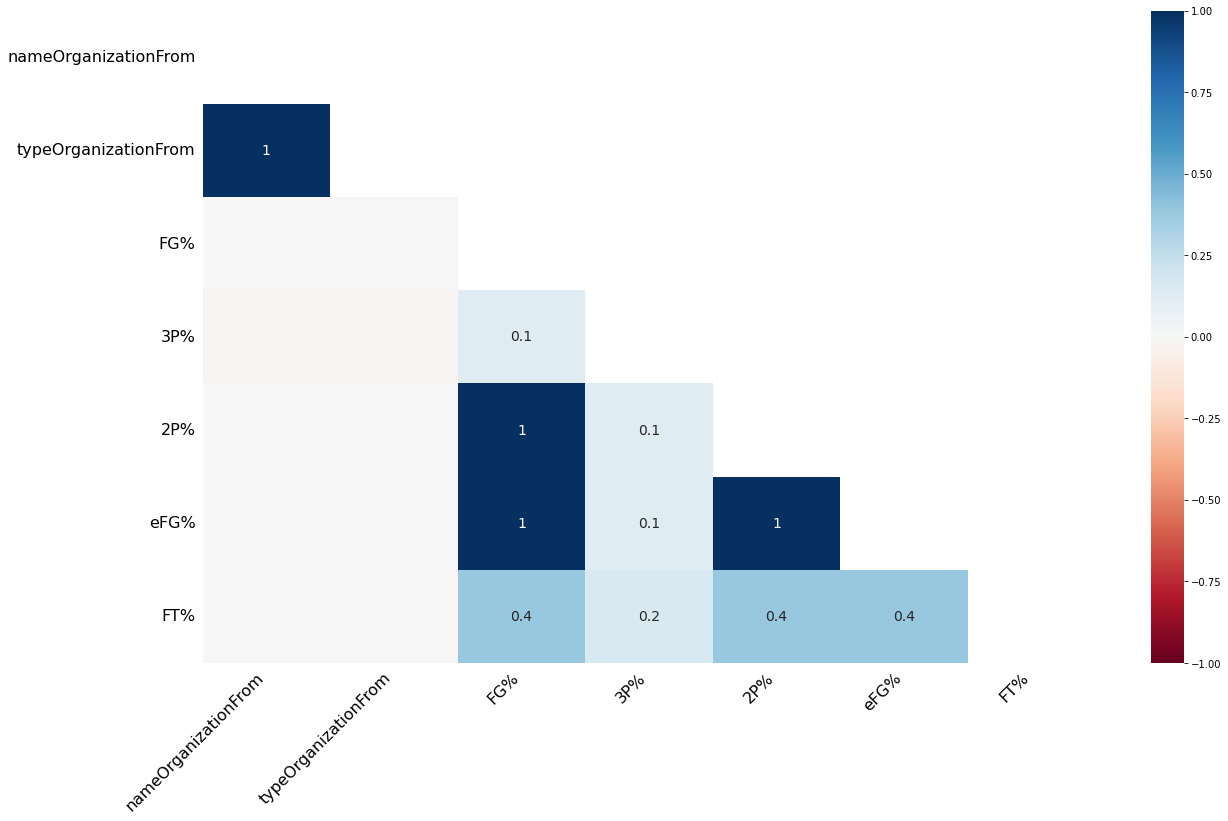

In [11]:
# inspect the correlations of the missing values  --> missings are dependent of each other (MAR)
missingno.heatmap(veterans_train)
plt.show()

For most of the players the majority of their points are field goals (FG), e.g. 2 Point shots. Therefore the correlation between the missings of the metrics 2P%, eFG% and FG% is identical with a correlation of 1: If the player didin't shoot any 2 point shot, there cannot be a percentage on those metrics. The imputation will be with a median, as explaiend above.

## 5. Deep Dive Correlations

Correlations between the predictor and target are good, but correlations between predictors (multicollinearity) can distort the regression model. Multicollinearity undermines the statistical significance of an independent variable (reducing the quality of the interpretation of the independent variables), eventhough it does not affect the accuracy of the prediction. 

First we have a look at the correlation heatmap, but with only the high correlations so it is not that overwhelming visually. Secondly we have a look at the correlations between the predictors and the target and choose to leave a variable out if reasonable.

In [12]:
# compute the df for corr with threshold for high correlations
corr_thresh = 0.7
veterans_corr = veterans_train.corr()[(veterans_train.corr() > corr_thresh) | (veterans_train.corr() < -corr_thresh)]

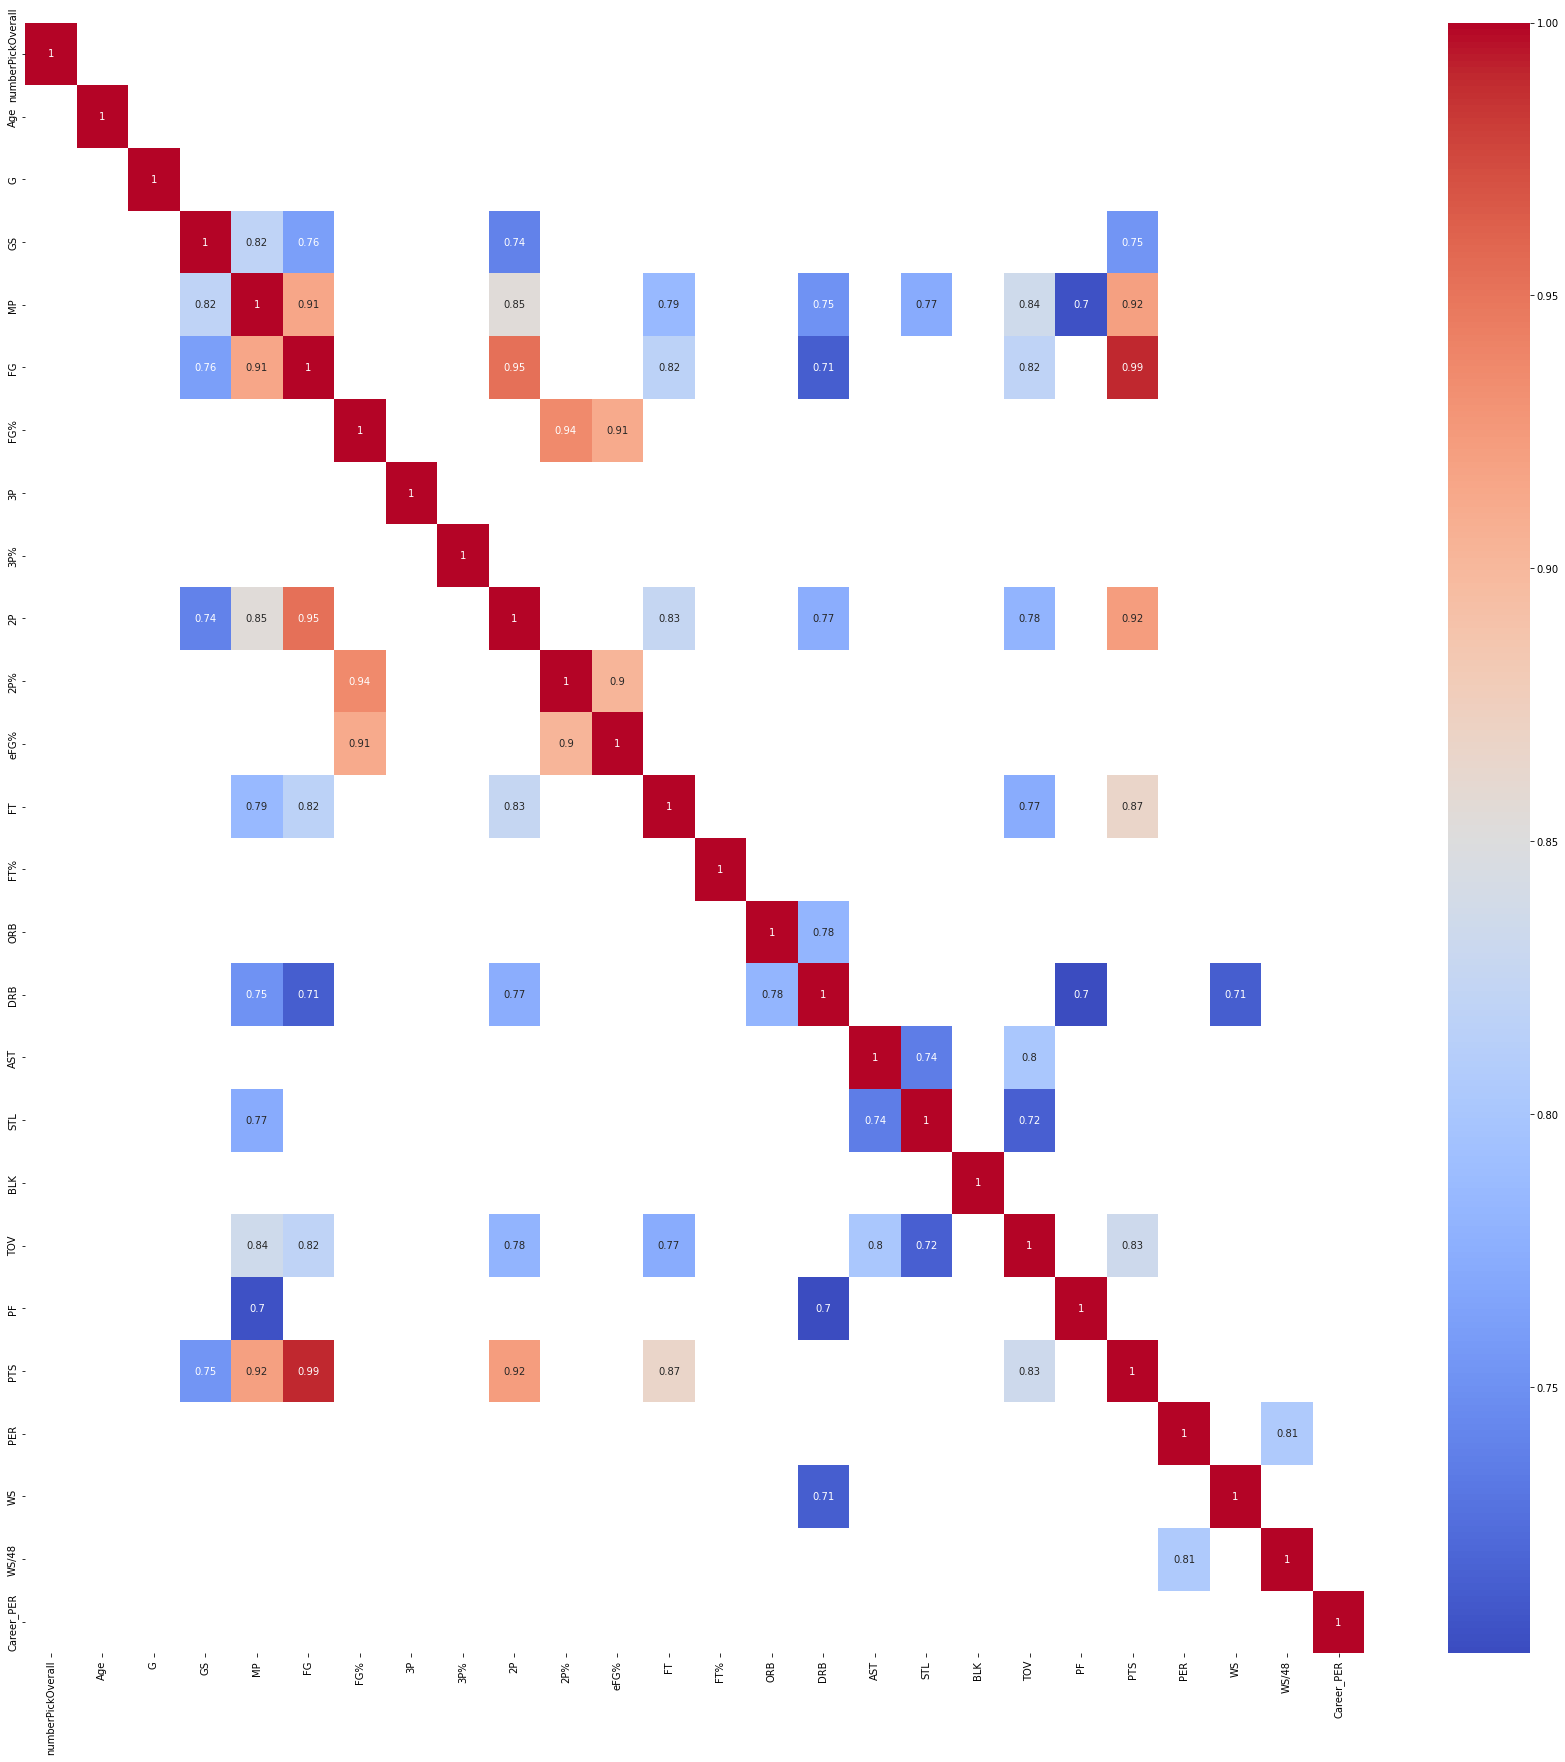

In [13]:
# visualize the correlations as a heatmap
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(veterans_corr, cmap='coolwarm', annot=True)
plt.show()

-- > There are a lot of high correlations that need to be dealt with in order to avoid multicollinearity. This is best done with PCA.

Now we have a look at the correlations between the predictors and the target.

In [14]:
# which predictors have the highest correlation with our target
round(pd.DataFrame(veterans_train.corr().loc[veterans_train.corr().index != 'Career_PER', ['Career_PER']]) \
                                        .sort_values(by='Career_PER', ascending=False), 2) \
                                        .style.background_gradient(cmap='coolwarm')

,Career_PER
WS,0.52
2P,0.49
FT,0.49
PER,0.46
DRB,0.45
FG,0.44
PTS,0.44
ORB,0.41
TOV,0.35
WS/48,0.34


The variables FT%, 3P and 3P% are probably not that predicitve because of their near zero correlations. They need further inspection for the decision wether to drop them or not. First, let's inspect all the correlations visually.

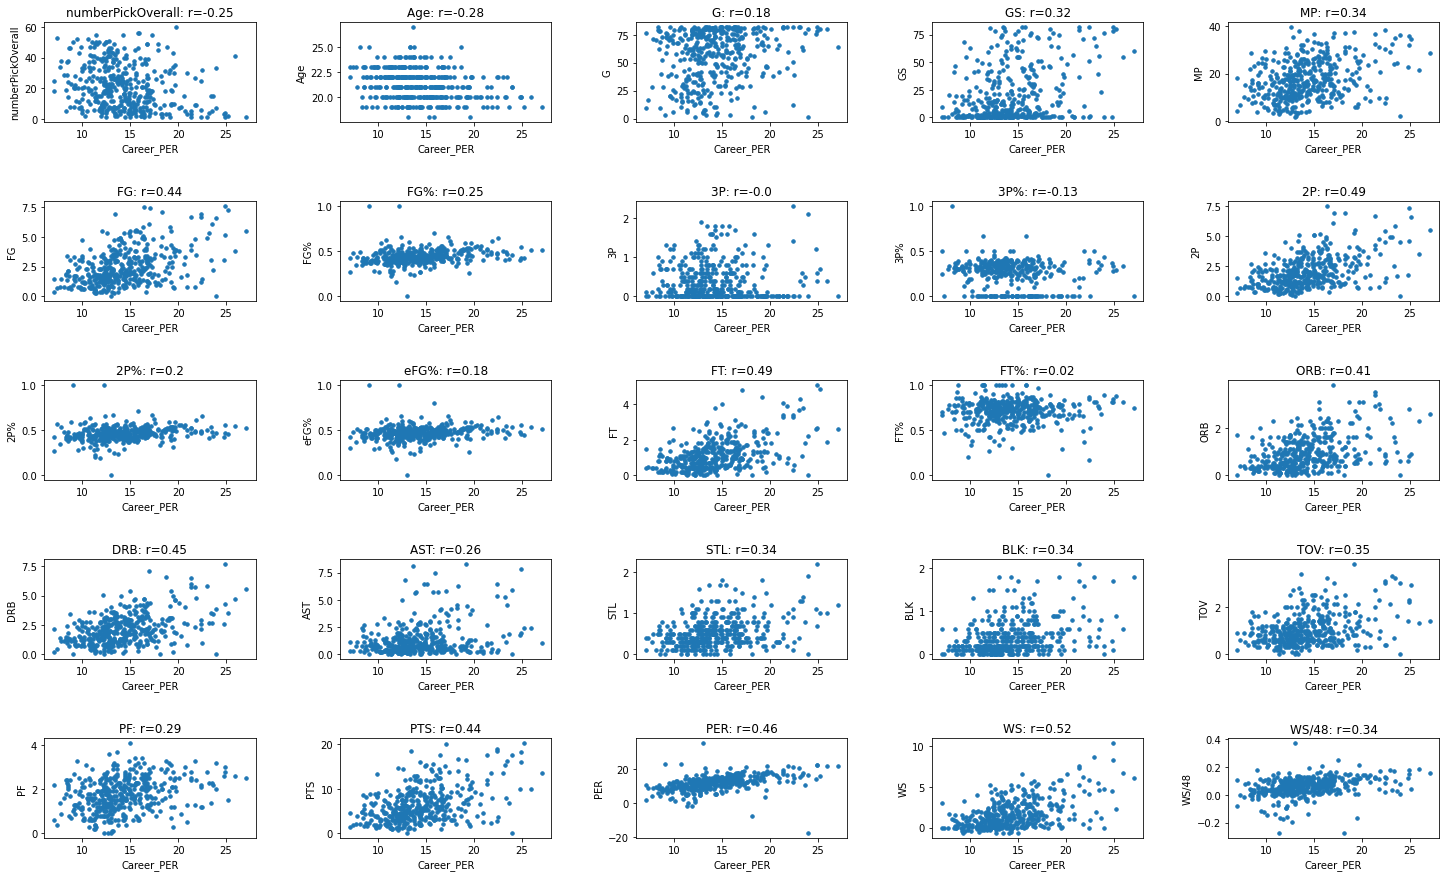

In [15]:
# Create figure with appropriate space between subplots
fig = plt.figure(figsize=(25, 15))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

# save corr in original order
corr_PER = veterans_train.corr().loc[veterans_train.corr().index != 'Career_PER', ['Career_PER']].squeeze().to_list()

for num, column in enumerate(veterans_train.select_dtypes('float').columns[:-1]):
    ax = fig.add_subplot(5, 5, num+1)  # 25 independent variables require 5x5
    ax.set_xlabel('Career_PER')
    ax.set_ylabel(column)
    ax.set_title(f'{column}: r={round(corr_PER[num], 2)}')
    ax.scatter(x=veterans_train['Career_PER'], y=veterans_train[column], s=12)
plt.show()

Next we have a deeper look at the weakly performing variables '3P', '3P%' and 'FT%'. Maybe the correlations are dependent on the different positions the players play in.

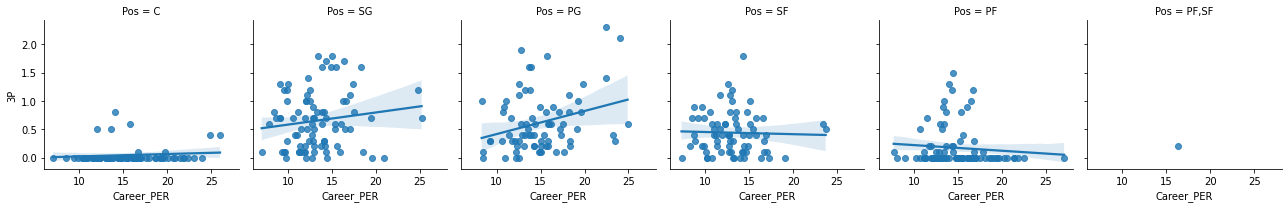

None

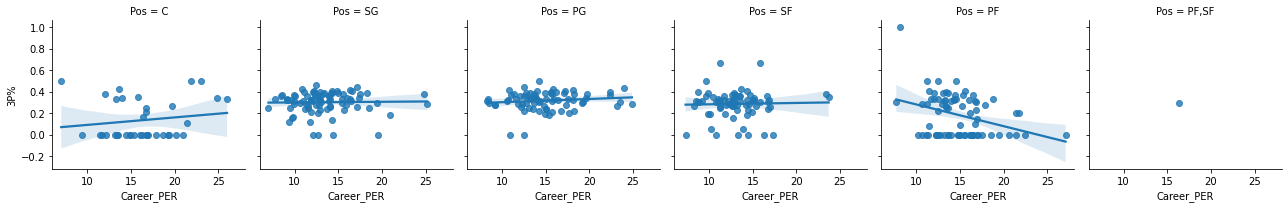

None

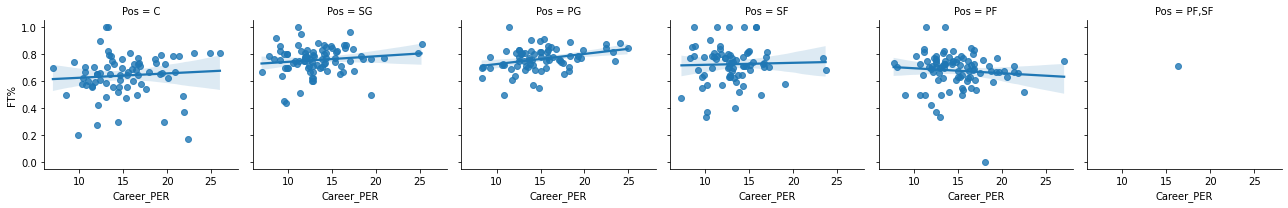

None

In [16]:
# function to plot in one output
def viz(column):
    g = sns.FacetGrid(veterans_train, col='Pos')
    g.map(sns.regplot, 'Career_PER', column)
    plt.show()

# inspect the variables FT%, 3P and 3P% with a position split
for column in ['3P', '3P%', 'FT%']:
    display(viz(column)) 

--> As we can visually see, the correlations are totally different for the different positions. Sometimes they even change from pos. to negative correlations. Also, there is only one PF,SF so we should assign this label to a bigger group (SF or PF) or drop the row (handled in the one-hot encoding later on). 

Baseline is: Overall the variables '3P', '3P%' and 'FT%' have a weak correlation, but within the different groups the certainly hold more information a nd we cannot drop them. Let's see the exact correlations.

In [17]:
grouped_corr_tables = []
for column in ['3P', '3P%', 'FT%']:
    grouped_corr_tables.append(pd.DataFrame(veterans_train.groupby('Pos')[column, 'Career_PER'] \
                                                          .corr()[['Career_PER']]) \
                                                          .iloc[::2, :] \
                                                          .sort_values(by='Career_PER', ascending=False))
                                                          
pd.concat(grouped_corr_tables, axis=0).style.background_gradient(cmap='coolwarm')

C:\Users\KEVING~1\AppData\Local\Temp/ipykernel_12044/3411692656.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_corr_tables.append(pd.DataFrame(veterans_train.groupby('Pos')[column, 'Career_PER'] \


,,Career_PER
Pos,,
PG,3P,0.29
SG,3P,0.14
C,3P,0.11
SF,3P,-0.03
PF,3P,-0.09
"PF,SF",3P,nan
C,3P%,0.16
PG,3P%,0.13
SF,3P%,0.03


## 6. Deep Dive Outliers

Outliers can distort the predictions of the model a lot. But there are different kinds of outliers: there are natural outliers like Lebron James when it comes to PER or Yao Ming when it comes to height. But there are also artificial outliers that shouldn't be there because they are an error in the data, they are not real. Those outliers should be removed for sure.

Another way to classify outliers are:
- **Global Outliers** (also called “Point Anomalies”): its value is far outside the entirety of the data set
- **Contextual Outliers** (also called “Conditional Outliers"): A data point is considered a contextual outlier if its value significantly deviates from the rest the data points in the same context
- **Collective Outliers**: A subset of data points within a data set is considered anomalous if those values as a collection deviate significantly from the entire data set

First, we view the standardized outliers with IQR of the Boxplots before we jump into the Isolation Forest.

### 6.1 Univariate and Contextual Outliers with IQR and Z-Scores

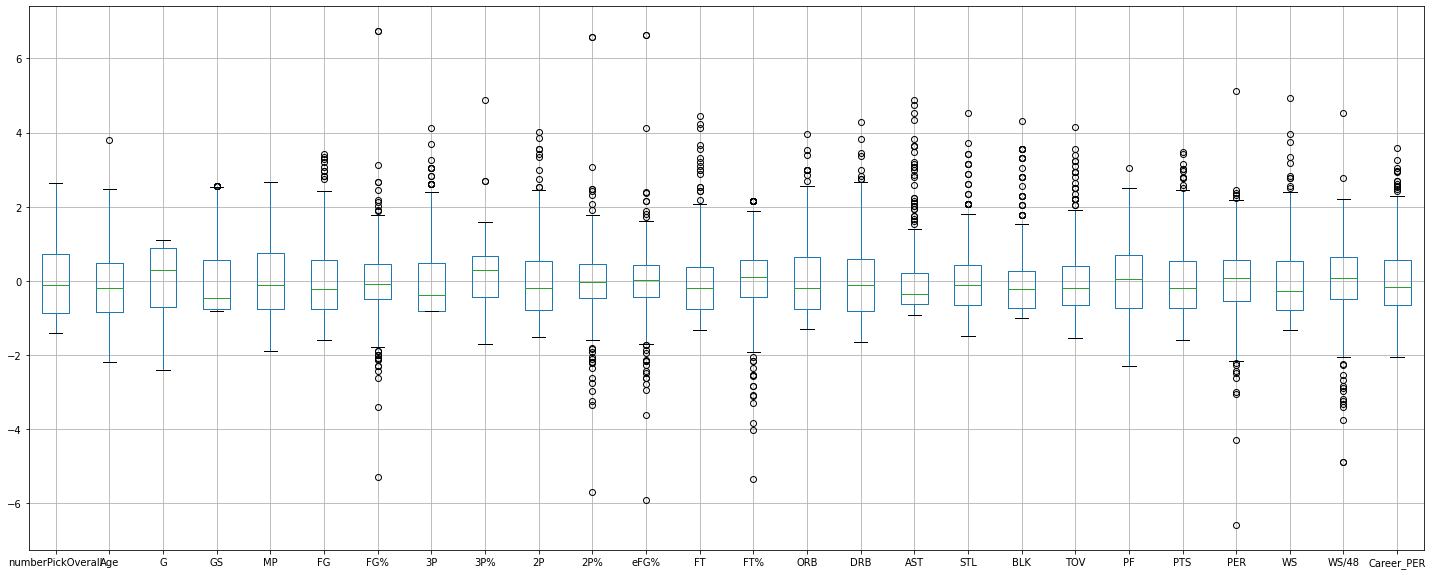

In [18]:
# select all numeric datatypes
veterans_train_numeric = veterans_train.select_dtypes(np.number)

# transform to the same scale + centering for better visualization
pd.DataFrame(StandardScaler().fit_transform(veterans_train_numeric), columns=veterans_train_numeric.columns).boxplot(figsize=(25, 10))
plt.show()

As realized earlier, the data is highly contextual to the position of the player. Let's view the contextual outliers with boxplots for each position:

********* Position = PG *********


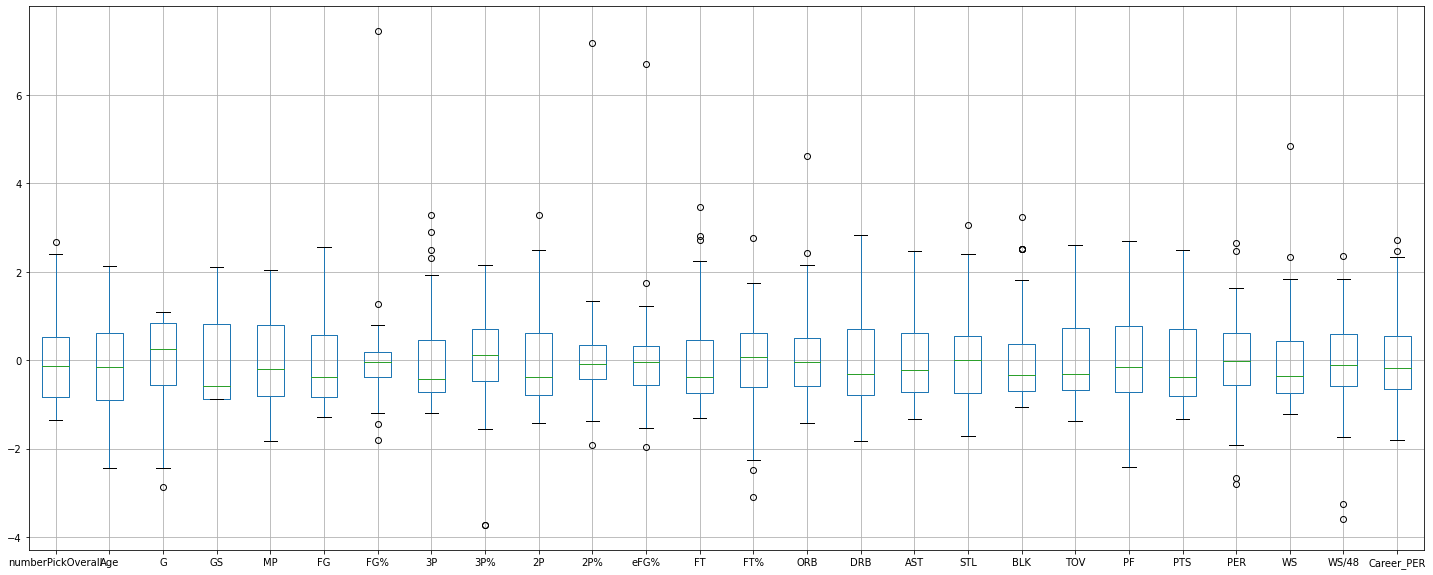

********* Position = SG *********


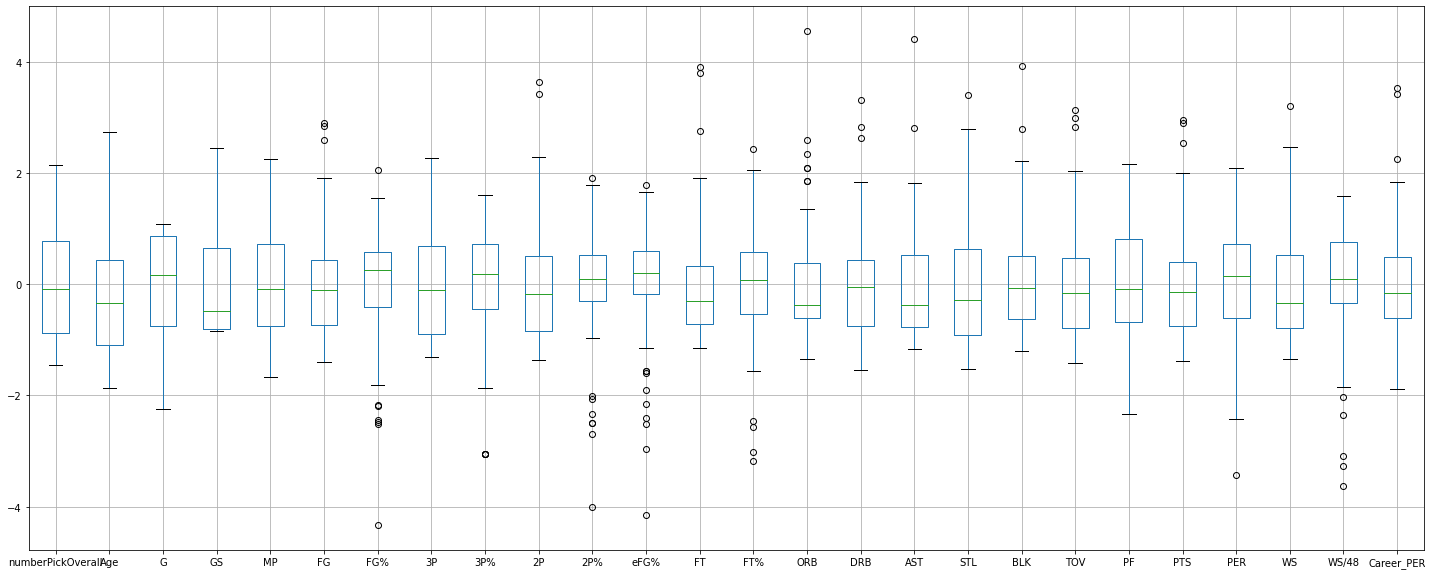

********* Position = C *********


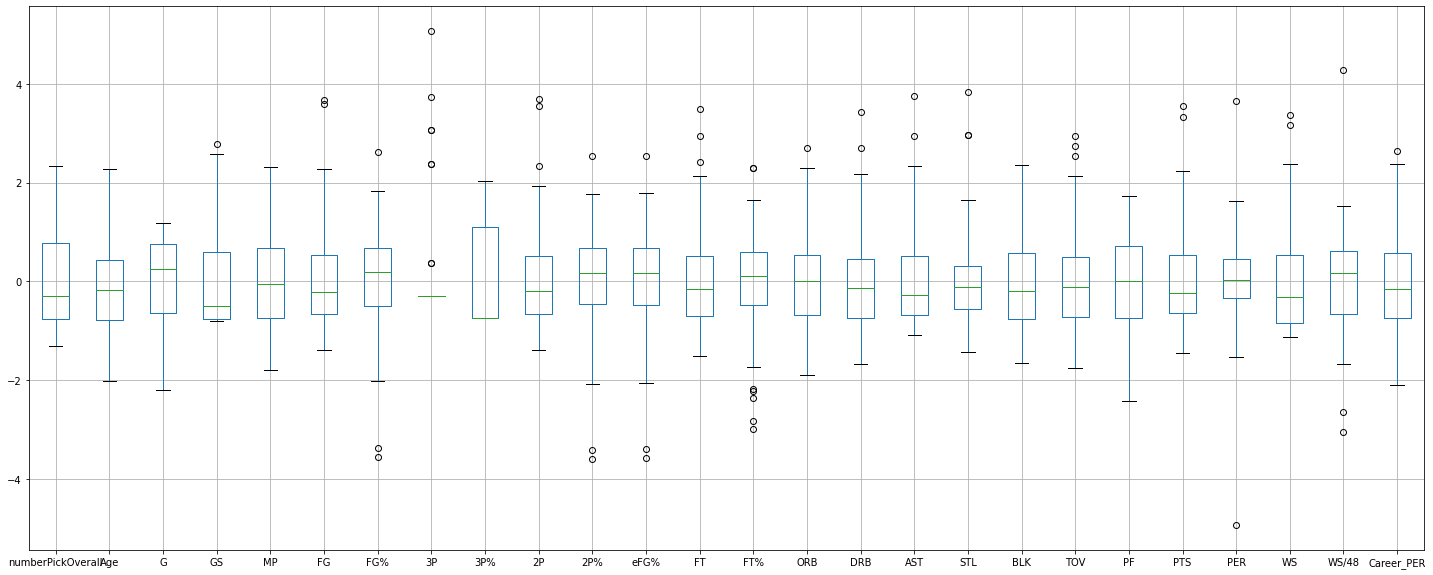

********* Position = SF *********


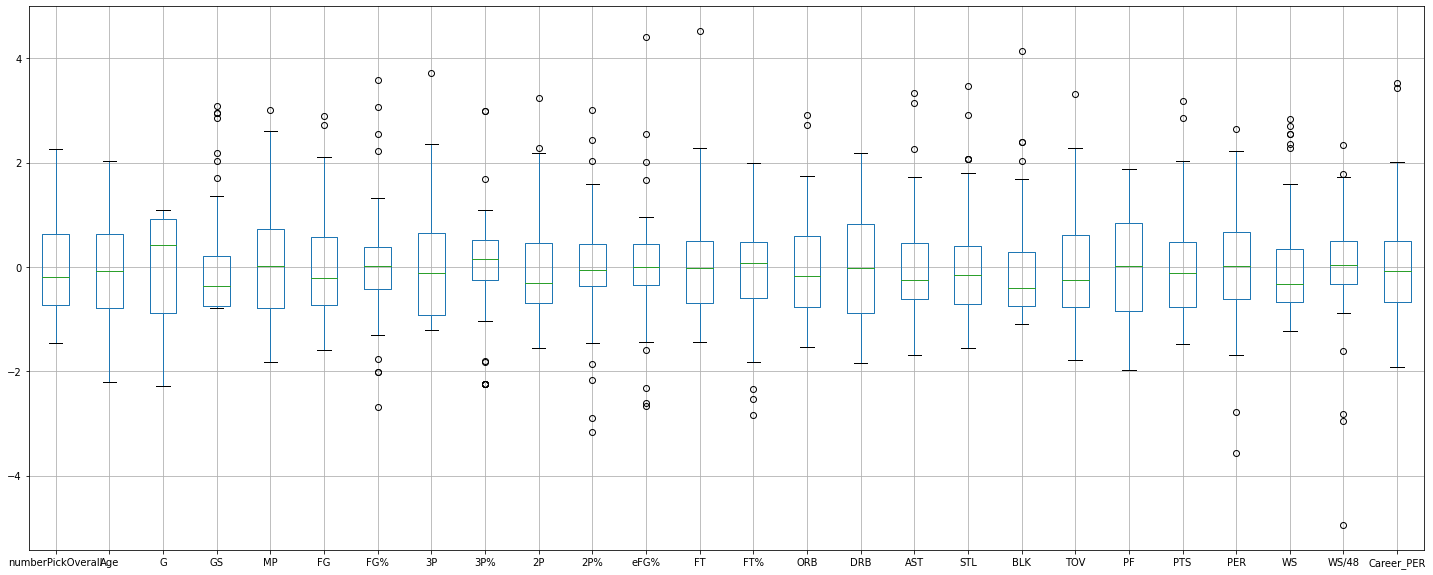

********* Position = PF *********


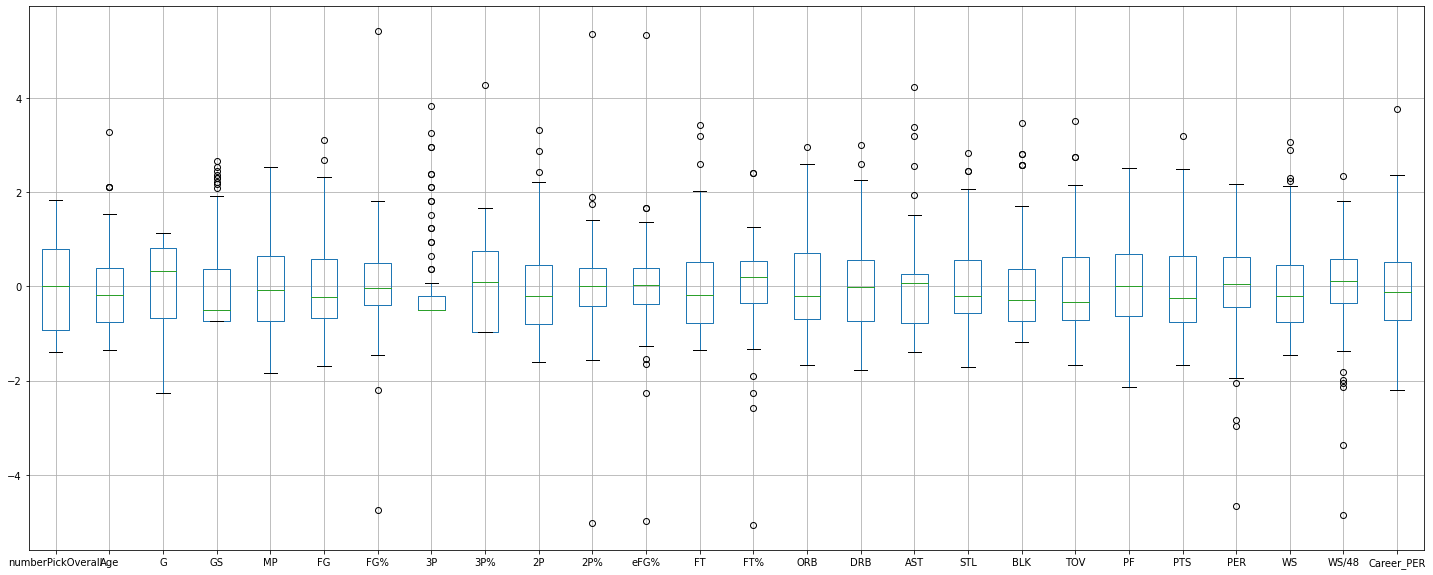

In [19]:
positions = ['PG', 'SG', 'C', 'SF', 'PF']

# loop through the pos and visualize each
for pos in positions:
    print(f'********* Position = {pos} *********')
    pos_data = veterans_train[veterans_train.Pos == pos]
    pos_data_numeric = pos_data.select_dtypes(np.number)
    pd.DataFrame(StandardScaler().fit_transform(pos_data_numeric), columns=pos_data_numeric.columns).boxplot(figsize=(25, 10))
    plt.show()

There are still a lot of univariate outliers when visualizing the z-scores with boxplots. Viewing the data univariately or just in one context (e.g. position) is dangerous, because the feature space is high-dimensional and all variables can possibly contribute to a data point being an outlier.

Therefore an isolation forest is applied and the result visualized in a 2-dimensional scatterplot.

In [20]:
# first separate the predictors from the target and keep the numeric ones
X = veterans_train_numeric.drop('Career_PER', axis=1)

In [21]:
# to guess the contamination (outliers in percent to total datapoints) we compute the percentage of univariate missings

k = 3  # set k to the favored value for outliers (1.5 - 3 is usual)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# filter df & compute percentage
outlier_mask = ((X < (Q1 - k * IQR)) | (X > (Q3 + k * IQR))).sum(axis=1) > 0
outlier_table = veterans_train[outlier_mask]
outliers_percentage = len(outlier_table) / len(veterans_train)

# show results
print(f'With bounds of k={k}*IQR there are {len(outlier_table)} total outliers (rows: {round(outliers_percentage*100, 2)}%).')
outlier_table

With bounds of k=3*IQR there are 37 total outliers (rows: 9.14%).


,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
197,Hassan Whiteside,33.0,Marshall,College/University,21.0,SAC,C,1.0,0.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-17.9,0.0,7.00e-03,24.0
233,Derrick Rose,1.0,Memphis,College/University,20.0,CHI,PG,81.0,80.0,37.0,7.1,0.47,0.2,0.22,6.9,0.49,0.48,2.4,0.79,1.2,2.7,6.3,0.8,0.2,2.5,1.5,16.8,16.0,4.9,7.80e-02,18.3
87,Trey Burke,9.0,Michigan,College/University,21.0,UTA,PG,70.0,68.0,32.3,4.9,0.38,1.6,0.33,3.3,0.41,0.44,1.5,0.90,0.5,2.4,5.7,0.6,0.1,1.9,2.1,12.8,12.6,0.9,2.00e-02,13.9
208,Brandon Jennings,10.0,Pallacanestro Virtus Roma,Other Team/Club,20.0,MIL,PG,82.0,82.0,32.6,5.5,0.37,1.8,0.37,3.7,0.37,0.43,2.7,0.82,0.6,2.8,5.7,1.3,0.2,2.4,2.3,15.5,14.5,4.2,7.50e-02,15.7
417,James Jones,49.0,Miami (FL),College/University,23.0,IND,SF,6.0,0.0,4.3,0.3,0.22,0.2,0.25,0.2,0.20,0.28,0.3,1.00,0.0,0.3,0.0,0.2,0.0,0.0,0.2,1.2,4.9,0.0,1.00e-02,11.3
346,Ian Mahinmi,28.0,STB Le Havre,Other Team/Club,21.0,SAS,C,6.0,0.0,3.8,1.0,0.50,0.0,NaN,1.0,0.50,0.50,1.5,1.00,0.0,0.8,0.2,0.0,0.7,0.3,0.7,3.5,35.3,0.2,3.72e-01,13.0
73,Clint Capela,25.0,Elan Chalon,Other Team/Club,20.0,HOU,C,12.0,0.0,7.5,1.2,0.48,0.0,NaN,1.2,0.48,0.48,0.3,0.17,0.8,2.2,0.2,0.1,0.8,0.4,1.2,2.7,12.1,0.0,1.90e-02,22.4
70,Bruno Caboclo,20.0,Esporte Clube Pinheiros,Other Team/Club,19.0,TOR,SF,8.0,0.0,2.9,0.5,0.33,0.3,0.67,0.3,0.22,0.42,0.0,NaN,0.1,0.1,0.0,0.0,0.1,0.5,0.4,1.3,-1.8,-0.1,-2.75e-01,11.3
505,Jason Hart,49.0,Syracuse,College/University,22.0,MIL,PG,1.0,0.0,10.0,1.0,1.00,0.0,NaN,1.0,1.00,1.00,0.0,NaN,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.7,0.0,-1.59e-01,12.2
110,Anthony Davis,1.0,Kentucky,College/University,19.0,NOH,PF,64.0,60.0,28.8,5.5,0.52,0.0,0.00,5.5,0.52,0.52,2.6,0.75,2.6,5.6,1.0,1.2,1.8,1.4,2.5,13.5,21.7,6.1,1.59e-01,27.1


### 6.2 Global Outliers with Isolation Forest

In [22]:
# impute missings so the iForest can handle the input
for col in X:
    X[col].fillna(X[col].median(), inplace=True)

# show result
X.isna().sum().sum()

0

In [ ]:
# build and fit the iforest
iforest = IsolationForest(contamination=0.1, bootstrap=True, n_jobs=-1, random_state=8)
iforest.fit(X)

# compute the outliers
X['Anomaly_Score'] = iforest.decision_function(X)  # negative is abnormal, the lower the more
X['Anomaly'] = iforest.predict(X)
X.loc[X['Anomaly'] == 1,'Anomaly'] = 0
X.loc[X['Anomaly'] == -1,'Anomaly'] = 1

In [25]:
# filter outliers
outliers = X[X.Anomaly==1]
veterans_train.loc[outliers.index, :]

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
266,Al Horford,3.0,Florida,College/University,21.0,ATL,C,81.0,77.0,31.4,4.1,0.50,0.0,0.00,4.1,0.50,0.50,1.9,0.73,3.1,6.6,1.5,0.7,0.9,1.7,3.3,10.1,14.7,5.5,0.10,18.7
475,Kenyon Martin,1.0,Cincinnati,College/University,23.0,NJN,PF,68.0,68.0,33.4,5.1,0.45,0.0,0.09,5.1,0.45,0.45,1.8,0.63,2.0,5.4,1.9,1.1,1.7,2.0,4.1,12.0,13.4,2.1,0.04,15.0
233,Derrick Rose,1.0,Memphis,College/University,20.0,CHI,PG,81.0,80.0,37.0,7.1,0.47,0.2,0.22,6.9,0.49,0.48,2.4,0.79,1.2,2.7,6.3,0.8,0.2,2.5,1.5,16.8,16.0,4.9,0.08,18.3
287,Carl Landry,31.0,Purdue,College/University,24.0,HOU,PF,42.0,0.0,16.9,3.2,0.62,0.0,0.00,3.2,0.62,0.62,1.7,0.66,2.3,2.6,0.5,0.4,0.2,0.6,2.3,8.1,21.4,3.7,0.25,17.5
425,Caron Butler,10.0,Connecticut,College/University,22.0,MIA,SF,78.0,78.0,36.6,5.5,0.42,0.4,0.32,5.1,0.43,0.43,4.0,0.82,1.7,3.4,2.7,1.8,0.4,2.5,2.9,15.4,15.1,5.1,0.09,15.0
79,Nikola Jokic,41.0,KK Mega Leks,Other Team/Club,20.0,DEN,C,80.0,55.0,21.7,3.8,0.51,0.4,0.33,3.5,0.54,0.54,1.9,0.81,2.3,4.7,2.4,1.0,0.6,1.3,2.6,10.0,21.5,6.7,0.18,26.0
24,Karl-Anthony Towns,1.0,Kentucky,College/University,20.0,MIN,C,82.0,82.0,32.0,7.6,0.54,0.4,0.34,7.3,0.56,0.56,2.7,0.81,2.8,7.7,2.0,0.7,1.7,2.2,3.0,18.3,22.5,8.3,0.15,24.9
235,O.J. Mayo,3.0,Southern California,College/University,21.0,MEM,SG,82.0,82.0,38.0,6.9,0.44,1.8,0.38,5.1,0.46,0.49,3.0,0.88,0.7,3.1,3.2,1.1,0.2,2.8,2.5,18.5,14.2,3.4,0.05,13.4
417,James Jones,49.0,Miami (FL),College/University,23.0,IND,SF,6.0,0.0,4.3,0.3,0.22,0.2,0.25,0.2,0.20,0.28,0.3,1.00,0.0,0.3,0.0,0.2,0.0,0.0,0.2,1.2,4.9,0.0,0.01,11.3
179,Greg Monroe,7.0,Georgetown,College/University,20.0,DET,C,80.0,48.0,27.8,3.8,0.55,0.0,0.00,3.8,0.55,0.55,1.8,0.62,3.1,4.4,1.3,1.2,0.6,1.0,2.5,9.4,18.0,6.6,0.14,20.1


Aas we can see, a lot of the outliers are natural outliers. Some of them were drafted on top of their year and are still on top of their game (Kevin Durant, John Wall, Kyrie Irving, etc).

### Plotting the data into 2-dimensional space with Seaborn

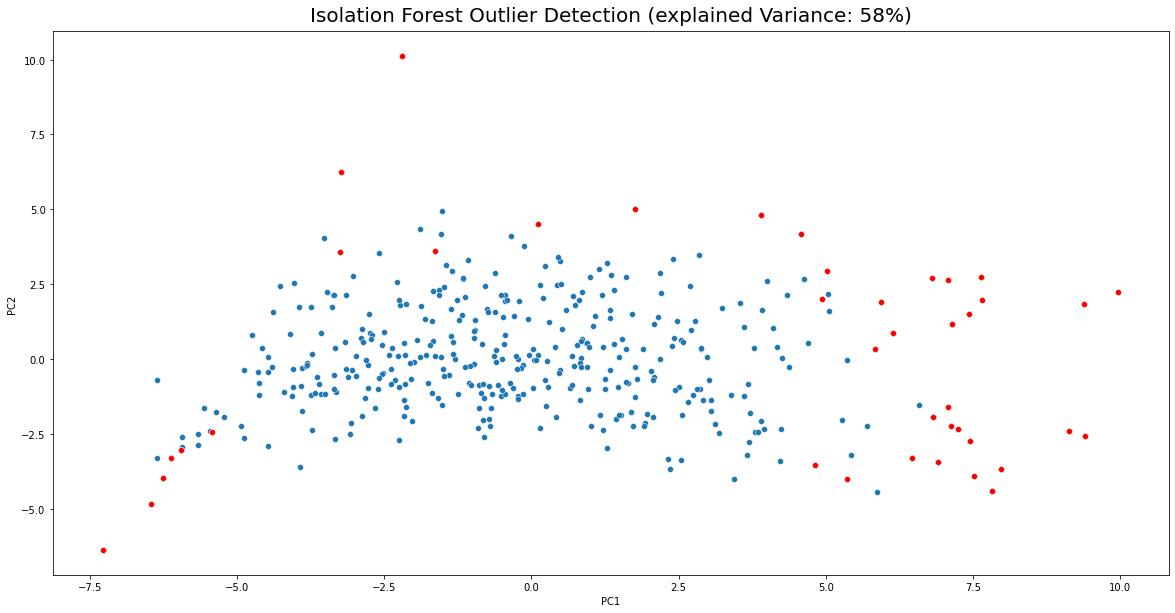

In [26]:
# Feature scaling 
sc=StandardScaler()
X_scaled = sc.fit_transform(X.iloc[:, :-2])
outliers_scaled = sc.transform(outliers.iloc[:, :-2])

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outliers_pca = pca.transform(outliers_scaled)
explained_variance = round(sum(pca.explained_variance_ratio_)*100)

# Plot the data
plt.figure(figsize=(20, 10))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outliers_pca[:,0], y=outliers_pca[:,1], color='r')
plt.title(f'Isolation Forest Outlier Detection (explained Variance: {explained_variance}%)', fontsize=20, pad=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

It would be nice to view the scatter plot and also see which player stands were. Let's try plotly for that task.

### Plotting the data into 2-dimensional space with Plotly

In [27]:
# Feature scaling 
sc=StandardScaler()
X_scaled = sc.fit_transform(X.iloc[:, :-2])

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = round(sum(pca.explained_variance_ratio_)*100)

# get df for viz
X_viz = pd.merge(pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X.index), veterans_train[['namePlayer', 'Pos', 'numberPickOverall', 'Career_PER']], left_index=True, right_index=True)
X_viz = pd.merge(X_viz, X[['Anomaly_Score', 'Anomaly']], left_index=True, right_index=True)
X_viz

,PC1,PC2,namePlayer,Pos,numberPickOverall,Career_PER,Anomaly_Score,Anomaly
413,-2.39,-0.34,Zaza Pachulia,C,42.0,14.6,1.12e-01,0
195,1.28,-2.97,Jordan Crawford,SG,27.0,14.1,3.50e-02,0
197,-6.37,-0.69,Hassan Whiteside,C,33.0,24.0,5.54e-03,0
92,-2.90,0.69,Shabazz Muhammad,SG,14.0,15.9,1.20e-01,0
146,3.66,-3.20,Brandon Knight,PG,8.0,13.7,5.07e-02,0
...,...,...,...,...,...,...,...,...
133,-2.17,-1.36,Draymond Green,SF,35.0,14.9,9.42e-02,0
361,7.63,2.74,Dwight Howard,PF,1.0,21.4,-6.26e-02,1
497,-5.43,-2.42,Mamadou N'diaye,C,26.0,13.3,-1.17e-04,1
340,0.02,-0.96,Jarrett Jack,SG,22.0,14.1,1.12e-01,0


In [28]:
# prepare columns for viz

normal = X_viz['Anomaly_Score'].max()
X_viz['Anomaly_Score_Viz'] = X_viz['Anomaly_Score'].map(lambda x: 0.01 if x>0 else round(np.abs(x), 2))  # size can only read positive numbers
X_viz['Anomaly'] = X_viz['Anomaly'].map(lambda x: 'Outlier' if x == 1 else 'Inlier')  # for discrete color scale

In [29]:
# vizualize the iForest results in an interactive 2D plot

fig = px.scatter(X_viz, x='PC1', y='PC2', color='Anomaly',
                 size='Anomaly_Score_Viz', hover_name='namePlayer',
                 hover_data={'PC1': False, 'PC2': False, 'Anomaly_Score_Viz': False, 'Anomaly': False, 'Pos': True, 'numberPickOverall': True, 'Career_PER': True},
                 labels={'Pos': 'Position', 'numberPickOverall': 'Draft Pick (Overall)', 'Career_PER': 'Player Efficiency Rating (Career Avg.)'},
                 title=f'<b>Isolation Forest Outlier Detection (explained Variance: {explained_variance}%)</b><br> Size of Circle equals outlier score - the bigger the circle the stronger the anomaly',
                 width=1000, height=600)
fig.update_layout(title_x=0.5)
fig.show(renderer='notebook_connected')

## 4. Conclusions & Actions of the EDA

- namePlayer is not relevant for the prediction accuracy but is carried over for inspection of final results
- nameOrganizationFrom has a high cardinality (149 = 41.3% distinct) and should therefore be target encoded
- There are a lot of high correlations which could distort the regression analysis due to multicollinearity --> PCA necessary
- The predictors '3P', '3P%' and 'FT%' have a low overall correlation with the target 'Career_PER' but they have higher correlations for the subgroups of positions so they will be kept for prediction
- the position label 'PF,SF' does only appear once and should therefore be labeled as missing, which is done in the one-hot encoding later on
- The missings in the categorical variables will be dealt with a one-hot encoded variable for missings. Most frequent makes no sense for such high cardinality and assumes MCAR (Missing Completely at Random)
- the missings in the numerical data are only for FG%, FT%, 3P%, 2P% and eFG%. This is dealt with a median over all, as explained earlier
- The distribution of the predictors is mostly not normal, so a PowerTransformer will be applied
- Automatic Removal of Outliers with iForest in Preprocessing Pipeline is not neccessary because they seem to be natural outliers that we want to capture as well with the model (we want to predict talents as well as mediocre players and the model needs this variance of data to learn from)
